### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
!pip install sentencepiece transformers datasets sacrebleu

     |████████████████████████████████| 1.2MB 14.8MB/s 
     |████████████████████████████████| 2.3MB 43.5MB/s 
     |████████████████████████████████| 225kB 60.1MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 901kB 47.5MB/s 
     |████████████████████████████████| 3.3MB 66.8MB/s 
     |████████████████████████████████| 245kB 57.9MB/s 
     |████████████████████████████████| 112kB 61.6MB/s 


In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

# import os
# path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
# if not os.path.exists(path_do_data):
#     print("Dataset not found locally. Downloading from github. Loading special files as well")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
#     path_do_data = './data.txt'

In [ ]:
import os
path_do_data = 'drive/MyDrive/nlp_made/data.txt'
# if not os.path.exists(path_do_data):
#     print("Dataset not found locally. Downloading from github. Loading special files as well")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
#     path_do_data = './data.txt'

In [ ]:
# if not os.path.exists('./utils.py'):
#     print("utils file not found locally. Downloading from github.")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

# if not os.path.exists('./my_network.py'):
#     print("network file not found locally. Downloading from github.")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [ ]:
# !pip install subword-nmt

In [ ]:
import json
import math
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
import spacy
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from nltk.tokenize import WordPunctTokenizer
import pandas as pd
import numpy as np
from datasets import load_dataset, load_metric

torch.manual_seed(4)
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9236
Unique tokens in target (en) vocabulary: 6723


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab['<unk>']

0

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'проживанием',
 'банкетный',
 'наслаждаться',
 'штате',
 'шотландский',
 'naxos',
 'хайдарабада',
 'единственный',
 'традициях']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'russian', 'krai', 'elegance', 'moments', 'shell', 'malia']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['situated', '400', 'metres', 'from', 'taksim', 'square', ',', 'the', 'heart', 'of', 'istanbul', ',', 'taksim', 'sheriff', 'suite', 'offers', 'self', '-', 'catering', 'accommodation', '.'], 'src': ['апартаменты', 'taksim', 'sheriff', 'suite', 'с', 'собственной', 'кухней', 'расположены', 'в', '400', 'метрах', 'от', 'площади', 'таксим', ',', 'в', 'центре', 'стамбула', '.']}


Let's check the length distributions:

Length distribution in Train data


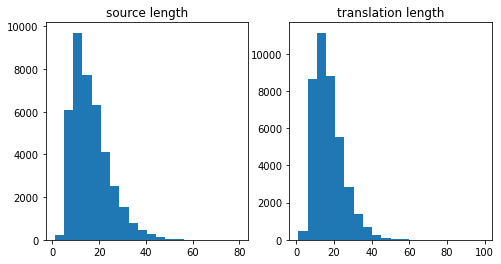

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


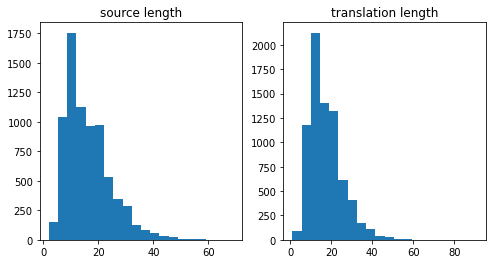

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key = _len_sort_key,
    sort_within_batch=True
)

In [ ]:
from drive.MyDrive.nlp_made import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9236, 128)
    (rnn): LSTM(128, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6723, 128)
    (rnn): LSTM(128, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6723, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,323,779 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 1

best_valid_loss = float('inf')

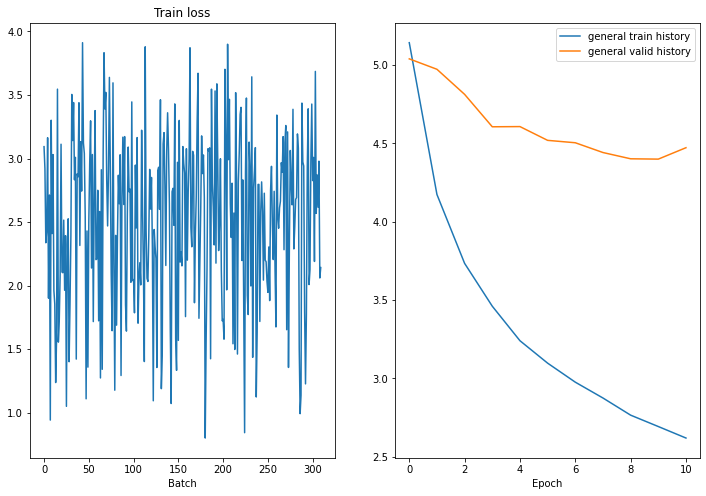

Epoch: 12 | Time: 0m 43s
	Train Loss: 2.509 | Train PPL:  12.290
	 Val. Loss: 4.454 |  Val. PPL:  85.965


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/nlp_made/basic-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# # Load with_scheduler model if you don't want to spend time on training
# model.load_state_dict(torch.load('drive/MyDrive/nlp_made/basic-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

__Let's take a look at our network quality__:

In [ ]:
from drive.MyDrive.nlp_made import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: you will find free shuttle service at the property .
Generated: there is a 24 - hour front desk at the property .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)
corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:03, 17.29it/s]


20.350818020560162

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

20.350818020560162

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

# Adding sheduler

Теперь попробуем добавить шедулер и немного поменять сеть и посмотрим, что нам это даст

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

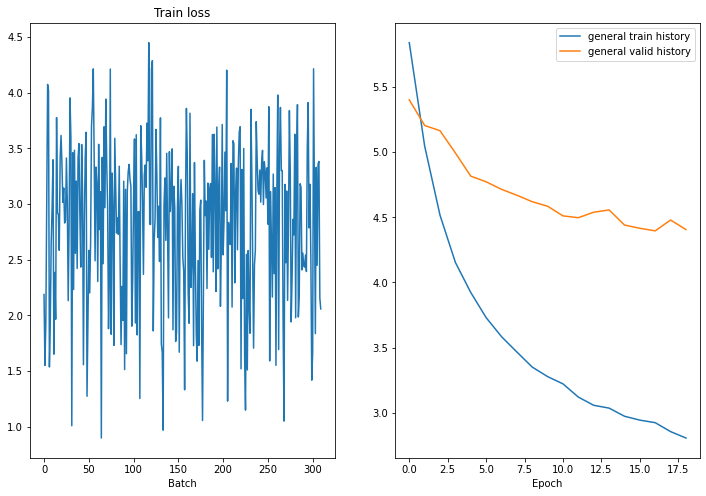

Epoch: 20 | Time: 0m 43s
	Train Loss: 2.814 | Train PPL:  16.681
	 Val. Loss: 4.395 |  Val. PPL:  81.065


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/nlp_made/with_scheduler-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# # Load with_scheduler model if you don't want to spend time on training
# model.load_state_dict(torch.load('drive/MyDrive/nlp_made/with_scheduler-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)
corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:03, 17.16it/s]


19.96172009551844

**Как видно, шедулер не сильно влияет на картину, поэтому стоит попробовать архитектуры помимо LSTM энкодера-декодера.**

Ниже, лучший из полученных вариантов, на LSTM

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
PAD_IDX = TRG.vocab.stoi['<pad>']
# optimizer = optim.Adam(model.parameters())
optimizer = optim.AdamW(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=0.05, step_size_up=1000)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 1

best_valid_loss = float('inf')

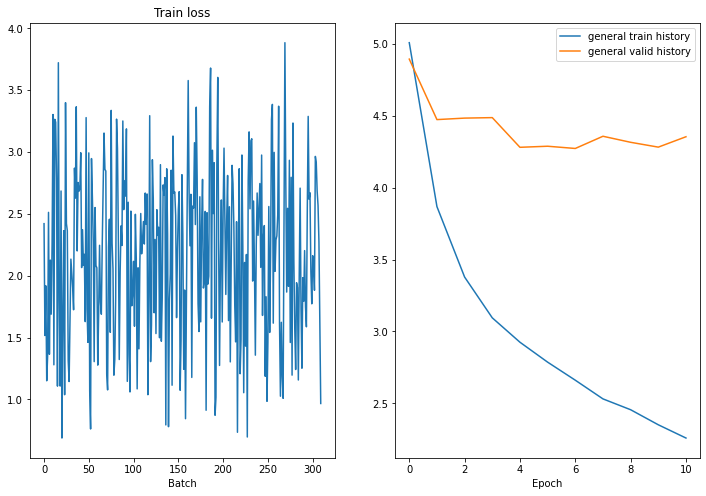

Epoch: 12 | Time: 0m 43s
	Train Loss: 2.162 | Train PPL:   8.690
	 Val. Loss: 4.371 |  Val. PPL:  79.130


In [ ]:
model.train()
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    # scheduler.step(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/nlp_made/best_basic-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# model.load_state_dict(torch.load('drive/MyDrive/nlp_made/best_basic-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)
corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:03, 17.19it/s]


23.90552050468262

In [ ]:
#Выбили 23.9 просто поменяв оптимайзер на adamw и снизив дропаут, что уже неплохо.

# CNN Encoder Decoder

Попробуем поменять архитектуру. 
Вместо классического энкодера и декодера в виде двух LSTM будем использовать CNN для энкодера и CNN с аттеншном для декодера. (+ positional encoding)
Архитектуру можно посмотреть в CNN_encoder_decoder_network.py

In [ ]:
from drive.MyDrive.nlp_made import CNN_encoder_decoder_network

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key = _len_sort_key,
    sort_within_batch=True
)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6730
cuda


In [ ]:
Encoder_cnn = CNN_encoder_decoder_network.Encoder
Decoder_cnn = CNN_encoder_decoder_network.Decoder
Seq2Seq_cnn = CNN_encoder_decoder_network.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder_cnn(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder_cnn(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq_cnn(enc, dec).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,139,722 trainable parameters


In [ ]:
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)


def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

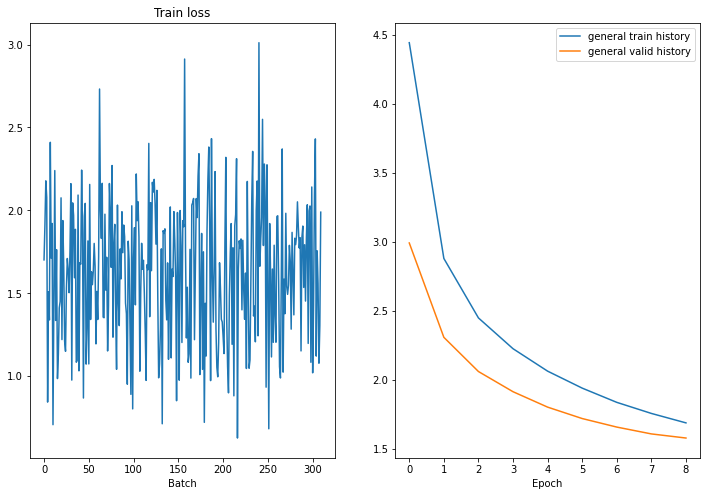

Epoch: 10 | Time: 0m 40s
	Train Loss: 1.629 | Train PPL:   5.100
	 Val. Loss: 1.552 |  Val. PPL:   4.719


In [ ]:
# from IPython.display import clear_output
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')
train_history=[]
valid_history=[]
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_cnn(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_cnn(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/nlp_made/cnn_enc_dec-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# model.load_state_dict(torch.load('drive/MyDrive/nlp_made/cnn_enc_dec-model.pt'))

# test_loss = evaluate_cnn(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['апартаменты', 'beach', 'village', 'praia', 'do', 'futuro', '1104', 'находятся', 'в', 'городе', 'форталеза', '.', 'к', 'услугам', 'гостей', 'открытый', 'бассейн', 'и', 'оздоровительный', 'спа', '-', 'центр', '.']
trg = ['located', 'in', 'fortaleza', ',', 'beach', 'village', 'praia', 'do', 'futuro', '1104', 'offers', 'an', 'outdoor', 'pool', 'and', 'a', 'spa', 'and', 'wellness', 'centre', '.']
predicted trg = ['located', 'in', 'fortaleza', ',', 'beach', 'village', 'praia', 'do', 'do', '<unk>', 'is', 'located', 'in', 'fortaleza', '.', '<eos>']


In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for i, datum in enumerate(data):
      
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)


In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.56


**Уже лучше, но все еще меньше 29. Можно попробовать оптимизировать гиперпараметры, но интереснее будет попробовать что-то еще**

# BERT

Теперь попробуем использовать Transformer архитектуру с self-attention и попробуем учить уже её. 
Архитектуру можно посмотреть в attention_network.py, но она практически полностью повторяет Трансформер из Attention is All You Need.

In [ ]:
from drive.MyDrive.nlp_made import attention_network

In [ ]:
Encoder_attention = attention_network.Encoder
Decoder_attention = attention_network.Decoder
Seq2Seq_attention = attention_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder_attention(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder_attention(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq_attention(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,826,890 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
train_attention = train_cnn
evaluate_attention = evaluate_cnn

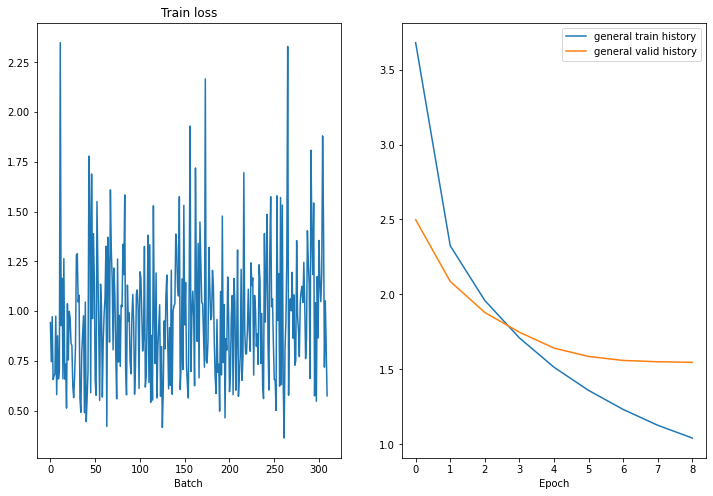

Epoch: 10 | Time: 0m 25s
	Train Loss: 0.967 | Train PPL:   2.629
	 Val. Loss: 1.588 |  Val. PPL:   4.895


In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_history=[]
valid_history=[]

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_attention(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_attention(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/nlp_made/attention-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# model.load_state_dict(torch.load('drive/MyDrive/nlp_made/attention-model.pt'))

# test_loss = evaluate_attention(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention


from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu_alt(test_iterator, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score[2]*100:.2f}')

BLEU score = 29.78


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu([[text[0]] for text in bleu_score[1]], bleu_score[0]) * 100

29.78242206716033

**Как мы видим, BERT молодец и отлично справляется с нашей задачей (BLEU 29.78). При этом учится он быстрее, чем RNN-based архитектуры, а по сравнению просто со сверточным энкодером и декодером с аттеншном он, даже имея в 4 раза меньше параметров показывает лучший результат.**

# Дообучение предобученного трансформера от HuggingFace (Helsinki-NLP/opus-mt-ru-en)

Для интереса можно попробовать использовать какую-нибудь из актуальных предобученных моделей и сравнить результаты с тем, что мы получили, обучаясь с нуля.

In [137]:
torch.cuda.empty_cache()

with open(path_do_data, 'r') as f:
    lines = f.readlines()
lines2 = [line.strip().split('\t') for line in lines]

model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"

In [ ]:
df = pd.DataFrame(lines2, columns=['en', 'ru'])
train_data, valid_data, test_data = np.split(df.sample(frac=1), [int(.8*len(df)), int(.95*len(df))])
json_train = {'data': {'translation': [{'en': line[0], 'ru': line[1]} for line in train_data.values]}}
json_valid = {'data': {'translation': [{'en': line[0], 'ru': line[1]} for line in valid_data.values]}}
json_test = {'data': {'translation': [{'en': line[0], 'ru': line[1]} for line in test_data.values]}}
with open('data_j_tr.json', 'w') as f:
    f.write(json.dumps(json_train))
with open('data_j_v.json', 'w') as f:
    f.write(json.dumps(json_valid))
with open('data_j_te.json', 'w') as f:
    f.write(json.dumps(json_test))

dataset_ = load_dataset('json', data_files={'train': 'data_j_tr.json', 'validation': 'data_j_v.json', 'test': 'data_j_te.json'}, field='data')

Using custom data configuration default-2d3481ab330f38dc


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-2d3481ab330f38dc/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.


In [ ]:
metric = load_metric("sacrebleu")

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

if "mbart" in model_checkpoint:
    tokenizer.src_lang = "ru_RU"
    tokenizer.tgt_lang = "en_XX"

if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "translate Russian to English: "
else:
    prefix = ""

In [ ]:
max_input_length = 128
max_target_length = 128
source_lang = "ru"
target_lang = "en"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = dataset_.map(preprocess_function, batched=True)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
batch_size = 32
args = Seq2SeqTrainingArguments(
    "test-translation",
    evaluation_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [136]:
# Тут слегка поломано выглядит обучение, но это просто из-за того, что колаб пытался умереть посередине:)
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.240400,1.078426,36.111900,20.702000
2,0.998300,1.008983,38.173700,20.910400
3,0.892900,0.982601,38.844000,20.858300


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.240400,1.078426,36.111900,20.702000
2,0.998300,1.008983,38.173700,20.910400
3,0.892900,0.982601,38.844000,20.858300
4,0.820000,0.967623,39.856800,20.956100
5,0.772000,0.964299,39.908200,20.948800


TrainOutput(global_step=6250, training_loss=0.9684755224609375, metrics={'train_runtime': 10220.6472, 'train_samples_per_second': 0.612, 'total_flos': 430045274112000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 306938368, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -6021120, 'train_mem_gpu_alloc_delta': 915111424, 'train_mem_cpu_peaked_delta': 11993088, 'train_mem_gpu_peaked_delta': 5188876288})

**Видим, предобученные модели сильно улучшают качество предсказаний, теперь у нас BLEU вырос до 40, что уже совсем хорошо для наших данных :)**

In [138]:
from transformers import pipeline

translator = pipeline("translation_ru_to_en", model=model, tokenizer=tokenizer, device=0)

Посмотрим на примеры перевода

In [156]:
inputs = test_data.loc[2, 'ru']

translation = translator(inputs, return_text=True)
translation = [t["translation_text"] for t in translation]
print([inputs])
print(translation)

['Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.']
['Located in Shanghai, Naigao Xiaowo offers free WiFi throughout the property.']


In [157]:
inputs = test_data.loc[18, 'ru']

translation = translator(inputs, return_text=True)
translation = [t["translation_text"] for t in translation]
print([inputs])
print(translation)

['Отель находится в 17 минутах езды от городка Валледории и в 34 км от города Порто-Торреса.']
['The property is a 17-minute drive from Valledoria and 34 km from Porto Torres.']


In [171]:
inputs = test_data.loc[32, 'ru']

translation = translator(inputs, return_text=True)
translation = [t["translation_text"] for t in translation]
print([inputs])
print(translation)

['Все номера располагают собственной ванной комнатой с душем и феном.']
['All rooms have a private bathroom with a shower and a hairdryer.']


Итого в работе помимо базовой модели были рассмотрены вырианты с:
1. Шедулерами
2. CNN encder decoder + attention + positional encoding
3. Transformer с self-attention
4. Дообучение transformer-align с normalization + SentencePiece предобученного на датасете OPUS (https://huggingface.co/Helsinki-NLP/opus-mt-ru-en)

Лучше всего показал себя предобученный трансформер, что логично, показав BLEU около 40. 
Перевод при этом выглядит вполне осмысленным.
Тюнингом гиперпараметров особо не занимался, здесь все-таки не соревнование, поэтому вероятно скор можно улучшить ещё за счет этого.

А так задание очень интересное, пришлось много разбираться в архитектурах и помогло пониманию продвинуться дальше "картинок со слоями" :)